<br> 
<span style="float: right; color: rgb(128, 128, 128); font-size:150%" >  <strong> Final Project - Milestone 1</span>
<span style="float: left; color: rgb(128, 128, 128); font-size:150%"> <strong>  42186 Model-based machine learning (F20)</span>    
    <br>  
  
    
    
  <span style="float: right; color: rgb(128, 128, 128)" >  <strong> Students:</span>
  <span style="float: left; color: rgb(128, 128, 128)"> <strong>  Professors:</span>
<div> 
      <br>  
<div>
  <span style="float: right" > Guðlaug Erlendsdóttir, s185717</span> 
  <span style="float: left"> Filipe Rodrigues</span>
<div> 
    <br>
  <span style="float: right" > Matthías Karl Karlsson, s182306</span> 
  <span style="float: left"> Francisco Camara Pereira</span>
    <br>
<div style="text-align: right"> Steinn Orri Erlendsson, s153716</div>
    
______________

## Table of Contents

### [1. Description of Project](#one)

* ####  [1.1. Research Question](#ResearchQuestion)

### [2. Data](#two)

* #### [2.1 Data Collection and Preprocessing](#two.one)

### [3.Natural Language Preprocessing](#three)

### [4. Descriptive Stats](#four)

### [5. Linear Regression - For comparison](#reg)

### [6. Generative Story & PGM](#six)

### [7. Inital STAN Model](#eight)

### [ Conclusion](#conclusion)


## The Simpsons - Topic Modeling with Latent Dirichlet Allocation(LDA)


In this notebook, topic modeling through Latent Dirichlet Allocation(LDA) is used in order to try uncover the topics that have come up on episodes of The Simpsons through the years. 

Attributes such as `rating` and `viewers` are extracted from [IMDB](IMDB) for the first 600 episodes of The Simpsons. 
Then, for each of these episodes, the description is scraped from [The Simpsons Fandom](page) page. 
There is a lot of data cleaning to be done, as there are a lot of missing values that resulted from the web scraping due to some inconstistency in the pages' setup. 
Natural Language Processing is deployed in order to represent the textual data better. Each episode's description was put through *TF-IDF analysis* in order to obtain a better representation of their description. 

By using LDA for topic modeling, the episodes can be seen as a mixture of topics, and therefore a relationhip between what is happening in the episode and its rating could potentially be made. Finally, a simple linear regression is used for comparison of the model's performance.

---


# 1. Description of Project<a class="anchor" id="one"></a>

For those that have ever watched the television show *The Simpsons*, it is quite known that the quality of episodes have dwindled over the past years. The show has been running for 30 years and it has long gone past its glory days. But what is the reason behind this decline in quality? In this notebook, the topics of each episode of *The Simpsons* is investigated and through *topic modeling* episodes are clustered together in order to see whether the topics of episodes have anything to do with their respective ratings. 

Ratings for 600 episodes were collected from [IMDB](https://www.imdb.com/) and descriptions for each of those episodes was collected from [The Simpsons Wiki Fanpage](https://simpsons.fandom.com/wiki/List_of_Episodes). This information, along with additional information collected from [Wikipedia](https://www.wikipedia.org) such as viewers per episode and airdate, was used in order to create a data set.

The probabilistic topic model *Latent Dirichlet Allocation* was used in order to extract topic proportions and allocations for each episode. These topics were then investigated in order to see if there is any apparent relationship between the topic of episodes over the years and their declining ratings. 

## 1.1. Research Question<a class="anchor" id="ResearchQuestion"></a>

By using *Topic Modeling* and *Latent Dirichlet Allocation*, we hope to uncover some of the hidden features of the episodes. In general, an episode's rating is related to what is happening in the episode. We want to find if there a relationship between the topic of episodes and their respective ratings, so our research question is;

> How do the topic proportions align with the episodes and can they be used to determine an episode's rating

If the topic allocations and proportions of an episode can help determine an episode's rating, not only have be created a better linear regression model, but we have proven a hypothesis which does seem logical. 

# 2. Data<a class="anchor" id="two"></a>

In this section, the method of collecting and preprocessing both the *ratings* and *description* for each episode is shown. All of the data is collected through web scraping. The websites that were scraped were [IMDB](https://www.imdb.com), [Wikipedia](https://www.wikipedia.org), and [The Simpsons Fandom Wiki Page](https://simpsons.fandom.com/wiki/List_of_Episodes). 

#### Importing packages

In [113]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib.request
import io
import re
import os
import os.path
import nltk, re, pprint
from nltk.tokenize import RegexpTokenizer
import sklearn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import collections
import colorsys
import warnings
warnings.filterwarnings("ignore")
from nltk import sent_tokenize
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
sns.set(style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = (16, 10)
import pystan
import pystan_utils
#make margins smaller 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
stop_words = stopwords.words('english')
for char in ['episode','begins']:
    stop_words.append(char)

**Color Palettes**

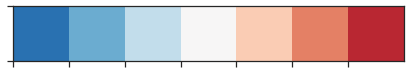

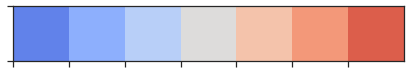

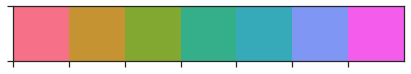

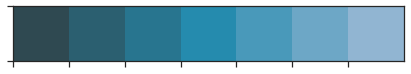

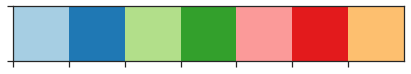

In [3]:
sns.palplot(sns.color_palette("RdBu_r", 7))
sns.palplot(sns.color_palette("coolwarm", 7))
sns.palplot(sns.color_palette("husl", 7))
sns.palplot(sns.color_palette("PuBuGn_d", 7))
sns.palplot(sns.color_palette("Paired", 7))


## 2.1 Data Collection and Preprocessing<a class="anchor" id="two.one"></a>

### Episode Information <a class="anchor" id="two.one.one"></a>

Getting all episode names, dates and relevant information is possible by scraping Wikipedia. This will serve as a basis for the episode information which will be used throughout the project. 

In [4]:
episode_1_20_url = 'https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1%E2%80%9320)#Episodes'
episode_21_31_url = "https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes"

In [5]:
res = requests.get(episode_1_20_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Simpsons Movie'):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
df_1 = pd.DataFrame(arr)
df_1.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 1 to 20:

In [6]:
df_1.head(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5
2,3,1,3,Homer's Odyssey,"January 21, 1990 (1990-01-21)",27.5


In [7]:
df_1.tail(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
438,439,20,19,"Waverly Hills, 9-0-2-1-D'oh","May 3, 2009 (2009-05-03)",6.75
439,440,20,20,Four Great Women and a Manicure,"May 10, 2009 (2009-05-10)",5.16
440,441,20,21,Coming to Homerica,"May 17, 2009 (2009-05-17)",5.86


Now, the rest of the seasons are retrieved:

In [8]:
res = requests.get(episode_21_31_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Longest Daycare' and table.previous.previous.previous.text):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
        if(season=='30'):
            break
df_2 = pd.DataFrame(arr)
df_2.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 21 to 30:

In [9]:
df_2.head(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
0,442,21,1,Homer the Whopper,"September 27, 2009 (2009-09-27)",8.31
1,443,21,2,Bart Gets a 'Z',"October 4, 2009 (2009-10-04)",9.32
2,444,21,3,The Great Wife Hope,"October 11, 2009 (2009-10-11)",7.5


In [10]:
df_2.tail(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
217,660,30,21,D'oh Canada,"April 28, 2019 (2019-04-28)",1.93
218,661,30,22,Woo-Hoo Dunnit?,"May 5, 2019 (2019-05-05)",1.79
219,662,30,23,Crystal Blue-Haired Persuasion,"May 12, 2019 (2019-05-12)",1.50


Concatinating them together will create the final dataframe for the episodes:

In [11]:
df_episodes = pd.concat([df_1,df_2])

In [12]:
df_episodes.reset_index(inplace=True)
df_episodes.drop('index',axis=1,inplace=True)

df_episodes['no_overall'] = df_episodes['no_overall'].apply(lambda x: int(x))
df_episodes['season'] = df_episodes['season'].apply(lambda x: int(x))
df_episodes['no_in_season'] = df_episodes['no_in_season'].apply(lambda x: int(x))

It is necessary to clean **season 28**, here episode **607**, are two seperate episodes.

In [13]:
df_episodes.iloc[607]

no_overall                                   608609
season                                           28
no_in_season                                   1213
episode_name          The Great Phatsby Parts 1 & 2
airdate               January 15, 2017 (2017-01-15)
viewers (millions)                             6.90
Name: 607, dtype: object

Splitting the episode up into episode **608** and **609** will make the data make more sense, as the overall episode count will be linear. 

In [14]:
df_episodes.drop(607,axis=0,inplace=True)

In [15]:
insert_into = pd.DataFrame(data = [{'no_overall':608, 'season':28,'no_in_season': 12, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}, {'no_overall':609, 'season':28,'no_in_season': 13, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}], index=[607,608])

df_episodes = pd.concat([df_episodes.iloc[:608], insert_into, df_episodes[608:]])

### Episode Ratings <a class="anchor" id="two.one.two"></a>

Getting the ratings for each episode is possible by scraping IMDB. There exist several pages of ratings for the series on IMDB. Going through each one of them will yield every episode's rating:

In [16]:
imdb_ratings_url = 'https://www.imdb.com/list/ls052175596/?st_dt=&mode=simple&page={}&ref_=ttls_vw_smp&sort=release_date,asc'
pages = range(1,8)

In [17]:
ratings = []
for page in range(1,8):
    url = imdb_ratings_url.format(page)
    res = requests.get(url).text
    soup = BeautifulSoup(res,'html')
    container = soup.find('div',class_='lister')
    for item in container.find_all('div', class_='lister-item'):
        as_ = item.find('span',class_='lister-item-header').find_all('a')
        episode_name = as_[1].text
        rating = item.find('div',class_='col-imdb-rating').text.strip()
        ratings.append([episode_name,rating])

df_ratings = pd.DataFrame(ratings)
df_ratings.columns = ['episode_name','IMDB rating']

In [18]:
df_ratings.tail(10)

,episode_name,IMDB rating
669,"Todd, Todd, Why Hast Thou Forsaken Me?",6.4
670,"Bobby, It's Cold Outside",6.7
671,Hail to the Teeth,6
672,The Miseducation of Lisa Simpson,6.6
673,Frinkcoin,5.9
674,Bart the Bad Guy,7.3
675,Screenless,6.6
676,Better Off Ned,6.5
677,Highway to Well,7
678,The Incredible Lightness of Being a Baby,6.4


For this particular project, only the first 660 episodes will be investigated. This decision was made as the last episodes do not have as much description written about them as they are quite new. 

In [19]:
df_ratings = df_ratings[:661]

In [20]:
df_ratings.tail(2)

,episode_name,IMDB rating
659,Woo-Hoo Dunnit?,5.9
660,Crystal Blue-Haired Persuasion,5.8


Concatinating these two DataFrames will yield more informative data. However, a simple merge on the names will not do because the names are not exactly identical on IMDB and Wikipedia. The `NaN` values will be looked at and manually fixed: 

In [21]:
df_episodes_ratings = pd.merge(df_episodes, df_ratings, on='episode_name',how='left')

The following episodes do not get a rating after the join because the naming convention are different between IMDB and Wikipedia.

In [22]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating
13,14,2,1,"Bart Gets an ""F""","October 11, 1990 (1990-10-11)",33.6,NaN
21,22,2,9,Itchy & Scratchy & Marge,"December 20, 1990 (1990-12-20)",22.2,NaN
28,29,2,16,"Bart's Dog Gets an ""F""","March 7, 1991 (1991-03-07)",23.9,NaN
88,89,5,8,Boy-Scoutz 'n the Hood,"November 18, 1993 (1993-11-18)",20.1,NaN
90,91,5,10,"$pringfield (or, How I Learned to Stop Worryin...","December 16, 1993 (1993-12-16)",17.9,NaN
123,124,6,21,The PTA Disbands!,"April 16, 1995 (1995-04-16)",11.8,NaN
127,128,6,25,Who Shot Mr. Burns? (Part One),"May 21, 1995 (1995-05-21)",15.0,NaN
128,129,7,1,Who Shot Mr. Burns? (Part Two),"September 17, 1995 (1995-09-17)",16.0,NaN
130,131,7,3,Home Sweet Homediddly-Dum-Doodily,"October 1, 1995 (1995-10-01)",14.5,NaN
134,135,7,7,King-Size Homer,"November 5, 1995 (1995-11-05)",17.0,NaN


A list of the names of the episodes that are missing their ratings can be created: 

In [23]:
missing = df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()].reset_index()
missing_episodes = missing['index']
for episode in missing_episodes:
    print(df_ratings.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating'])

Bart Gets an F 8.2
Itchy and Scratchy and Marge 8.1
Bart's Dog Gets an F 7.5
Boy Scoutz 'n the Hood 8.7
$pringfield (Or, How I Learned to Stop Worrying and Love Legalized Gambling) 8.6
The PTA Disbands 8.1
Who Shot Mr. Burns? Part One 9.2
Who Shot Mr. Burns? Part Two 9
Home Sweet Home-Dum-Diddly Doodily 8.4
King Size Homer 9
The Simpsons 138th Episode Spectacular! 7.5
Raging Abe Simpson and His Grumbling Grandson in 'The Curse of the Flying Hellfish' 8.4
Summer of 4'2" 8.4
El Viaje Misterioso De Nuestro Jomer 8.6
Homer vs. the 18th Amendment 8.9
Lisa Gets an 'A' 8.1
Homer Simpson in: 'Kidney Trouble' 7.3
Marge Simpson in 'Screaming Yellow Honkers' 7.3
The Old Man and the 'C' Student 7.3
Thirty Minutes Over Tokyo 8
Alone Again, Natura-Diddly 7.7
Lisa the Treehugger 7.1
Homr 8.1
Hungry Hungry Homer 7.5
Bye Bye Nerdy 6.6
I Am Furious Yellow 7.7
Papa's Got a Brand New Badge 7.8
Bart vs. Lisa vs. 3rd Grade 7.1
Today, I Am a Clown 6.4
I, (Annoyed Grunt)-Bot 7.2
Co-Dependent's Day 6.7
Thank G

As can be seen by comparing the two lists, these are the episodes that are missing a rating in the final dataframe. Now, an array can be created with the ratings of these episodes, extracted from `df_ratings`. 

In [24]:
missing_ratings = []
for episode in missing_episodes:
    missing_ratings.append([episode,df_episodes.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating']])

In [25]:
for episode in missing_ratings: 
    index = episode[0]
    rating = episode[2]
    df_episodes_ratings.at[index, 'IMDB rating'] = rating

In [26]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating


The DataFrame holding each episode's information along with it's rating is now complete, but the airdate column can use a little bit of cleaning:

In [27]:
df_episodes_ratings.head(2)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7,8.2
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5,7.7


In [28]:
df_episodes_ratings['year'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[0])
df_episodes_ratings['month'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[1].split('-')[0])
df_episodes_ratings['day'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[2].replace(")",""))

In [29]:
df_episodes_ratings.head(2)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating,year,month,day
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7,8.2,1989,12,17
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5,7.7,1990,01,14


The Airdate column can now be dropped:

In [30]:
df_episodes_ratings.drop('airdate',axis=1,inplace=True)

And finally, the IMDB rating column should hold float values:

In [31]:
df_episodes_ratings['IMDB rating'] = df_episodes_ratings['IMDB rating'].apply(lambda x: float(x))

There are still some `NaN` values in the column `viewers (millions)`

In [32]:
df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A']

,no_overall,season,no_in_season,episode_name,viewers (millions),IMDB rating,year,month,day
159,160,8,7,Lisa's Date with Density,N/A,7.8,1996,12,15
160,161,8,8,Hurricane Neddy,N/A,8.8,1996,12,29
172,173,8,20,The Canine Mutiny,N/A,7.6,1997,04,13


These values will be set as the average of the viewers for the season that they belong to.

In [33]:
avg_season_8 = np.average([float(viewer) for viewer in df_episodes_ratings[(df_episodes_ratings['viewers (millions)'] != 'N/A') & (df_episodes_ratings['season'] == 8)]['viewers (millions)']])

The values that need to be filled in are in places 159, 160 and 172:

In [34]:
fill_na_indices = [index for index in df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A'].reset_index()['index']]

In [35]:
for index in fill_na_indices:    
    df_episodes_ratings.at[index,'viewers (millions)'] = avg_season_8

This column should also hold float values.

In [36]:
df_episodes_ratings['viewers (millions)'] = df_episodes_ratings['viewers (millions)'].apply(lambda x: float(x))

In [37]:
df_episodes_ratings.isna().sum()

no_overall            0
season                0
no_in_season          0
episode_name          0
viewers (millions)    0
IMDB rating           0
year                  0
month                 0
day                   0
dtype: int64

In [38]:
df_episodes_ratings.to_csv('episode_ratings.csv')

### Simpsons.fandom Pages of Each Episode <a class="anchor" id="two.one.four"></a>

In order to scour through each episode's description, scraping a Wiki fan-page of the series is necessary.

In [39]:
wiki_url = 'https://simpsons.fandom.com/wiki/List_of_Episodes'

In [40]:
links_array = []
res = requests.get(wiki_url).text
soup = BeautifulSoup(res,'html')
no_overall = 1
for table in soup.find_all('table', class_='wikitable')[1:31]: #Skip the overview table and only take the first 30 seasons
    for row in table.find_all('tr'):
            links = row.find_all('a')
            for link in links:
                if(link['href'].split('/wiki/')[1] != 'The_Simpsons_Movie'):
                    links_array.append([no_overall,link['href'].split('/wiki/')[1]])
                    no_overall = no_overall + 1

In [41]:
df_episode_wiki = pd.DataFrame(links_array)
df_episode_wiki.columns = ['no_overall','wiki_link']

In [42]:
df_episode_wiki

,no_overall,wiki_link
0,1,Simpsons_Roasting_on_an_Open_Fire
1,2,Bart_the_Genius
2,3,Homer%27s_Odyssey
3,4,There%27s_No_Disgrace_Like_Home
4,5,Bart_the_General
...,...,...
656,657,Girl%27s_in_the_Band
657,658,I%27m_Just_a_Girl_Who_Can%27t_Say_D%27oh
658,659,D%27oh_Canada
659,660,Woo-hoo_Dunnit%3F


Again, the episode 'The Great Phatsby' (episode 608/609), is causing problems. It can be solved as we did before:

In [43]:
phatsby_insert = pd.DataFrame({'no_overall':609, 'wiki_link':'The_Great_Phatsby'},index=[608])
phatsby_insert
df_episode_wiki = pd.concat([df_episode_wiki.iloc[:608], phatsby_insert, df_episode_wiki[608:]])
df_episode_wiki.reset_index(inplace=True, drop=True)
df_episode_wiki_no_correction = df_episode_wiki.iloc[609:]
df_episode_wiki_no_correction['no_overall'] = df_episode_wiki_no_correction['no_overall'].apply(lambda x: x+1)
df_episde_wiki = pd.concat([df_episode_wiki.iloc[:608], df_episode_wiki_no_correction])

In [44]:
df_episodes_ratings = pd.merge(df_episodes_ratings,df_episode_wiki)

In [45]:
df_episodes_ratings.head(5)

,no_overall,season,no_in_season,episode_name,viewers (millions),IMDB rating,year,month,day,wiki_link
0,1,1,1,Simpsons Roasting on an Open Fire,26.7,8.2,1989,12,17,Simpsons_Roasting_on_an_Open_Fire
1,2,1,2,Bart the Genius,24.5,7.7,1990,01,14,Bart_the_Genius
2,3,1,3,Homer's Odyssey,27.5,7.4,1990,01,21,Homer%27s_Odyssey
3,4,1,4,There's No Disgrace Like Home,20.2,7.7,1990,01,28,There%27s_No_Disgrace_Like_Home
4,5,1,5,Bart the General,27.1,8.0,1990,02,04,Bart_the_General


### Creating Text Files of Episodes <a class="anchor" id="two.one.five"></a>

Here, each description is fetched and saved as a text file in order to attach them to the data set later. 

In [46]:
if not os.path.exists('synopsis'):
        os.mkdir('synopsis')
        
not_full_story = ['Mr._Spritz_Goes_to_Washington', 
                  'Three_Gays_of_the_Condo', 
                  'The_Fat_and_the_Furriest', 
                  'Today,_I_Am_a_Clown', 
                  'Simple_Simpson', 
                  'Fat_Man_and_Little_Boy', 
                  'My_Fare_Lady', 
                  'To_Courier_with_Love', 
                  'Lisa_Gets_the_Blues', 
                  'Girl%27s_in_the_Band',
                  'A_Star_is_Born-Again',
                  'Milhouse_Doesn%27t_Live_Here_Anymore']

for season in df_episodes_ratings['season'].unique():
    if not os.path.exists('synopsis/'+'season'+str(season)):
        os.mkdir('synopsis/'+'season'+str(season))

save_path = os.getcwd()+'/synopsis/'
for episode in df_episodes_ratings['wiki_link']:
    syn = " "
    
    res = requests.get("https://simpsons.fandom.com/wiki/{}".format(episode)).text
    ep_number = df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['no_overall'].values[0]
    season = int(df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['season'].values[0])
    
    soup = BeautifulSoup(res,'html')
    
    # Remove all images
    figs = soup.findAll('figure')
    for fig in figs:
        fig.decompose()
        
    h3s = soup.findAll('h3')
    for h3 in h3s:
        h3.decompose()

    if(episode in not_full_story):
        parent = soup.find('span', {'id':'Synopsis'}).parent
        sibling = parent.next_sibling
        while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name==''):
            if(sibling.name == 'p' or sibling.name=='a'):
                syn += ' ' + str(sibling.text)
                sibling = sibling.next_sibling
            else:
                sibling = sibling.next_sibling

            
    else:

        if(soup.find('span', {'id':'Full_Story'})):
            
            parent = soup.find('span', {'id':'Full_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'The_Story'})):
            
            parent = soup.find('span', {'id':'The_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_story'})):
            
            parent = soup.find('span', {'id':'Full_story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'Plot'})):
            
            parent = soup.find('span', {'id':'Plot'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name=='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_Story.C2.A0'})):
            
            parent = soup.find('span', {'id':'Full_Story.C2.A0'}).parent
            sibling = parent.next_sibling

            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

                    
    complete_name = os.path.join(os.path.expanduser('~'),save_path+'season'+str(season)+'/',str(ep_number)+'.txt')

    with io.open(complete_name, "w", encoding="utf-8") as f: 
        f.write(str(syn))
        f.close()

It is then necessary to copy episode 608 and create episode 609, as these two episodes are the same episode - often referred to as episode "608609". 

In [47]:
save_path = os.getcwd()+'/synopsis/season28/'
path = save_path+"608.txt"
text = io.open(path,'r',encoding='utf-8').read()
with io.open(save_path+'609.txt', "w", encoding="utf-8") as f: 
    f.write(str(text))
    f.close()

In [48]:
rows = []
for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = desc.lower()
        rows.append([ep,desc])
        f.close()

In [49]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])

In [50]:
df_desc[df_desc['desc']==' ']

,no_overall,desc
167,168,
256,257,
321,322,
364,365,
430,431,
642,643,
645,646,
659,660,


## 3. Natural Language Processing<a class="anchor" id="three"></a>

In order to represent the text data better, some useful natural language processing methods had to be used. 

First, all *stopwords*, along with the word "*episode*", will be removed from the descriptions as they do not pertain any information about the episode itself. 

Then, the description is split into *tokens* (words) and lastly we use stemming. The words can then be analyzed. 

In [51]:
rows = []
ps = PorterStemmer() 

for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = re.sub(r'[^\w]', ' ', desc)
        desc = re.sub(" \d+", " ", desc) #removing numbers
        desc = ps.stem(desc)
        desc = desc.replace('  ',' ').replace('\n','')[1:]
        desc = [word.lower() for word in desc.split(' ') if word.lower() not in stop_words and len(word)>1]
        rows.append([ep, desc])
        f.close()

In [52]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])
df_desc = df_desc[:600]

Next, a column is created in order to display the length of each description.

In [53]:
df_desc['len'] = df_desc['desc'].apply(lambda x: len(x))

In [54]:
df = df_episodes_ratings.merge(df_desc, on='no_overall')

In [55]:
df.columns

Index(['no_overall', 'season', 'no_in_season', 'episode_name',
       'viewers (millions)', 'IMDB rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'len'],
      dtype='object')

In [56]:
df.columns = ['no_overall', 'season', 'no_in_season', 'episode_name',
       'mil_viewers', 'rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'len']

In [57]:
df.drop('wiki_link',axis=1,inplace=True)

In [58]:
df['mil_viewers'] = df['mil_viewers'].apply(lambda x: float(x))

In [59]:
df['day'] = df['day'].replace('22[a]','22')

In [60]:
df['no_overall'] = df['no_overall'].apply(lambda x: int(x))
df['no_in_season'] = df['no_in_season'].apply(lambda x: int(x))
df['season'] = df['season'].apply(lambda x: int(x))
df['year'] = df['year'].apply(lambda x: int(x))
df['month'] = df['month'].apply(lambda x: int(x))
df['day'] = df['day'].apply(lambda x: int(x))
df['rating'] = df['rating'].apply(lambda x: float(x))

The data set now looks like this, where the column *desc* is essentially a bag of words for each episode. 

In [61]:
df.sample(10)

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,len
527,528,24,20,The Fabulous Faker Boy,4.16,6.1,2013,5,12,"[marge, bart, school, conference, principal, s...",147
489,490,23,4,Replaceable You,7.97,6.4,2011,11,6,"[itchy, scratchy, show, lisa]",4
529,530,24,22,Dangers on a Train,4.52,6.7,2013,5,19,"[homer, marge, celebrating, wedding, anniversa...",123
71,72,4,13,Selma's Choice,24.50,8.0,1993,1,21,"[great, aunt, gladys, dies, simpsons, attend, ...",133
198,199,9,21,Girly Edition,8.50,7.9,1998,4,19,"[krusty, clown, show, coming, criticism, fcc, ...",197
451,452,21,11,Million Dollar Maybe,5.11,6.9,2010,1,31,"[homer, marge, kwik, mart, barney, bart, meanw...",70
399,400,18,22,You Kent Always Say What You Want,9.80,7.1,2007,5,20,"[driving, home, appointment, dentist, homer, k...",331
196,197,9,19,Simpson Tide,9.00,8.2,1998,3,29,"[homer, lenny, carl, want, doughnut, one, left...",240
293,294,14,3,Bart vs. Lisa vs. the Third Grade,13.30,7.1,2002,11,17,"[family, bored, reality, shows, six, major, ne...",200
24,25,2,12,The Way We Was,26.80,8.3,1991,1,31,"[tv, shorts, marge, tells, kids, story, homer,...",305


The following episodes are the episodes which do not have a description. These episodes will be removed from the dataset before any model is built.

In [62]:
df[df['len']==0]

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,len
167,168,8,15,Homer's Phobia,15.30,8.8,1997,2,16,[],0
256,257,12,9,HOMR,18.50,8.1,2001,1,7,[],0
321,322,15,9,"I, (Annoyed Grunt)-bot",16.30,7.2,2004,1,11,[],0
364,365,17,9,Simpsons Christmas Stories,9.80,6.8,2005,12,18,[],0
430,431,20,11,How the Test Was Won,6.52,6.9,2009,3,1,[],0


In [63]:
all_words = []
for desc in df['desc']:
    for word in desc:
        all_words.append(word)

In [64]:
Counter(all_words).most_common(20)

[('homer', 6088),
 ('bart', 3870),
 ('marge', 2999),
 ('lisa', 2633),
 ('family', 997),
 ('springfield', 865),
 ('burns', 835),
 ('back', 808),
 ('tells', 748),
 ('one', 670),
 ('however', 657),
 ('get', 656),
 ('go', 583),
 ('moe', 580),
 ('home', 579),
 ('school', 550),
 ('gets', 539),
 ('new', 501),
 ('milhouse', 500),
 ('house', 496)]

The most common words that appear in the descriptions are words that one would expect to appear often in a description of any episode of The Simpsons. In order to represent the uniqueness of each episode and make the *textual data* more descriptive, *TF-IDF analysis* was deployed.

### TF-IDF Analysis

All English stopwords, along with the word *episode*, have been removed from the description before this point. 

In order to perform TF-IDF analysis, the unique set of words used over all the episodes need to be represented as a collection. 

The computations of the tf-idf values was greatly inspired by this following [article](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76)

In [65]:
unique_words = set(all_words)

In [66]:
len(unique_words)

17526

In [67]:
word_dict = Counter(all_words)

Each episode will now have their own *term frequency*, i.e. how often a word appears in the description of the episode divided by the total words used to describe the episode.

*Inverse Data Frequency* is then the log of the number of episodes, divided by the number of episodes that contain the word *w* in their description. 

Then, in order to compute the TF-IDF, these terms are multiplied together. Each word will get a tf-idf score for all the words that appear in all descriptions of episodes. 

In [68]:
'''
words: Array of words
returns: Dictionary of the words with their respective tf value
'''

def tf(words):
    from collections import Counter
    tf_dict = {}
    word_counts = Counter(words)
    for word in word_counts:
        count = word_counts[word]
        tf_dict[word] = count / len(words)
    return tf_dict

In [69]:
def idf(documents):
    import math
    N = len(documents)
    keys = []
    for doc in documents:
        keys += doc.keys()
    idfDict = dict.fromkeys(keys, 0)
    for i,document in enumerate(documents):
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [70]:
def tf_idf(tf, idfs):
    tfidf = {}
    for word, val in tf.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [71]:
documents = []
for i,row in df.iterrows():
    documents.append(Counter(row['desc']))

In [72]:
idfs = idf(documents)

From these methods a new method can be created that returns an episode's top $200$ words relative to their tf-idf scores. 

In [73]:
def get_top_tf_idf(words):
    if(len(words)<1):
        return []
    df_idf = pd.DataFrame.from_dict(tf_idf(tf(words),idfs),orient='index').reset_index()
    df_idf.columns = ['word','score']
    return list(df_idf.sort_values(by='score', ascending=False)[:200].reset_index(drop=True)['word'].values)

A column can then be added to the data set, listing the top *descriptive* words for each episode in respect to their tf-idf scores. 

In [74]:
df['tf_idf'] = df['desc'].apply(get_top_tf_idf)

In [75]:
df

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,len,tf_idf
0,1,1,1,Simpsons Roasting on an Open Fire,26.70,8.2,1989,12,17,"[homer, hastily, drives, family, sedan, marge,...",1223,"[christmas, santa, tattoo, lights, bonus, whir..."
1,2,1,2,Bart the Genius,24.50,7.7,1990,1,14,"[simpson, family, playing, scrabble, living, r...",702,"[pryor, martin, test, kwyjibo, gifted, genius,..."
2,3,1,3,Homer's Odyssey,27.50,7.4,1990,1,21,"[front, springfield, elementary, mrs, krabappe...",703,"[intersection, balcony, plant, safety, piggy, ..."
3,4,1,4,There's No Disgrace Like Home,20.20,7.7,1990,1,28,"[bart, lisa, fighting, long, homer, quickly, r...",359,"[monroe, normal, family, neighborhood, dr, pic..."
4,5,1,5,Bart the General,27.10,8.0,1990,2,4,"[inside, simpsons, kitchen, lisa, baking, cupc...",448,"[nelson, grandpa, herman, cupcakes, inside, ar..."
...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,27,22,Orange Is the New Yellow,2.54,6.7,2016,5,22,"[homer, leaving, power, plant, weekend, promis...",217,"[prison, realized, homemaker, trouble, guard, ..."
596,597,28,1,Monty Burns' Fleeing Circus,3.36,6.0,2016,9,25,"[simpsons, taking, walk, springfield, observe,...",302,"[presentation, bowl, burns, statue, laughingst..."
597,598,28,2,Friends and Family,6.00,6.5,2016,10,2,"[mr, burns, goes, appointment, counselor, deal...",226,"[julia, virtual, burns, recordings, friendship..."
598,599,28,3,The Town,3.22,7.0,2016,10,9,"[homer, goes, moe, watch, football, game, spri...",234,"[boston, americans, cap, cation, team, move, i..."


##  4. Descriptive Stats <a class="anchor" id="four"></a>

The final data set is comprised of 600 rows where each row represents an episode of *The Simpsons*, and 12 feature columns. Each episode gets an overall rating between 0.0 and 10.0, although the minimum and maximum ratings in this dataset are $3.9$ and $9.3$ respectively. 

Each episode (row) has a feature called `desc` which holds the words used to describe the episode. 

In [76]:
df.shape

(600, 12)

The following tables show some basic stats about the data set.

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   no_overall    600 non-null    int64  
 1   season        600 non-null    int64  
 2   no_in_season  600 non-null    int64  
 3   episode_name  600 non-null    object 
 4   mil_viewers   600 non-null    float64
 5   rating        600 non-null    float64
 6   year          600 non-null    int64  
 7   month         600 non-null    int64  
 8   day           600 non-null    int64  
 9   desc          600 non-null    object 
 10  len           600 non-null    int64  
 11  tf_idf        600 non-null    object 
dtypes: float64(2), int64(7), object(3)
memory usage: 60.9+ KB


In [78]:
df.describe()

,no_overall,season,no_in_season,mil_viewers,rating,year,month,day,len
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,300.500000,14.100000,11.585000,11.839150,7.313667,2002.713333,6.043333,14.936667,299.650000
std,173.349358,7.755444,6.549881,6.409896,0.821221,7.769283,3.928168,8.345782,182.500397
min,1.000000,1.000000,1.000000,2.320000,3.900000,1989.000000,1.000000,1.000000,0.000000
25%,150.750000,7.000000,6.000000,7.037500,6.700000,1996.000000,3.000000,8.000000,195.750000
50%,300.500000,14.000000,11.000000,10.300000,7.100000,2003.000000,5.000000,14.500000,269.000000
75%,450.250000,21.000000,17.000000,15.150000,8.000000,2010.000000,10.000000,21.000000,359.000000
max,600.000000,28.000000,25.000000,33.600000,9.300000,2016.000000,12.000000,31.000000,1405.000000


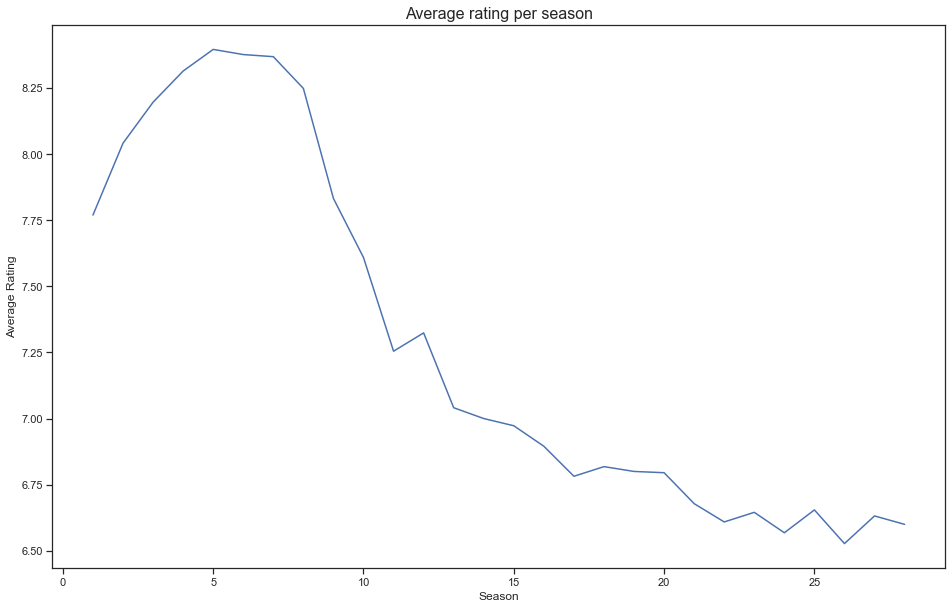

In [79]:
sns.lineplot(x='season',y='rating',data=df.groupby('season').mean()['rating'].reset_index())
plt.title("Average rating per season", size=16)
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.show()

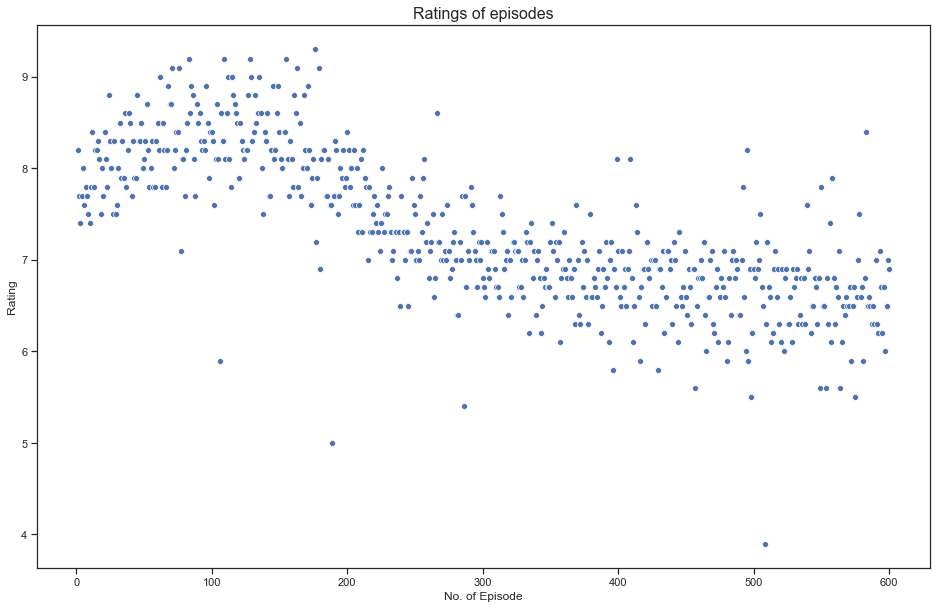

In [80]:
sns.scatterplot(x='no_overall',y='rating',data=df)
plt.title("Ratings of episodes", size=16)
plt.xlabel("No. of Episode")
plt.ylabel("Rating")
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


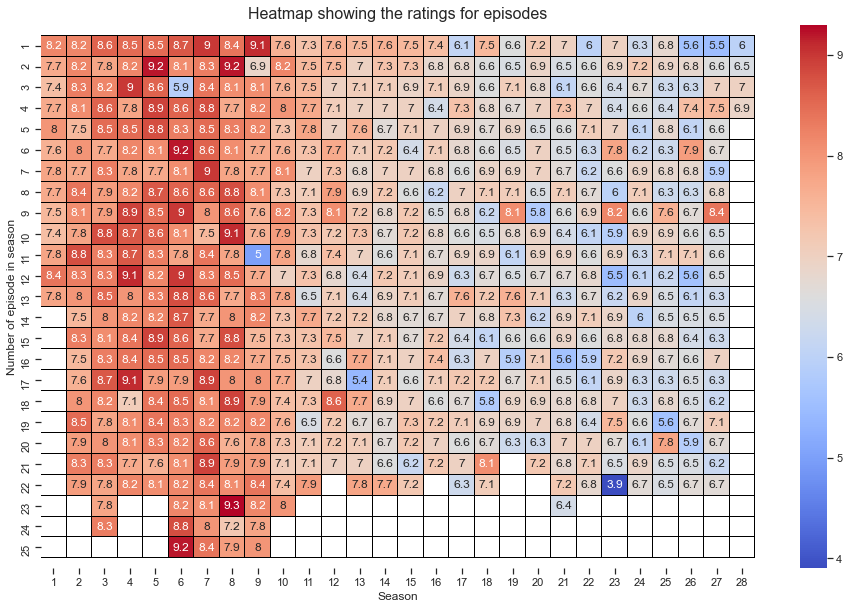

In [81]:
ax = sns.heatmap(df[['rating','no_in_season','season']].pivot_table(columns='season',index='no_in_season',values='rating'),
                 annot=True,
                 cmap='coolwarm',
                linewidth=0.05,
                linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatmap showing the ratings for episodes", size=16)
plt.ylabel("Number of episode in season")
plt.xlabel("Season")
plt.show()

The past three plots visualize the decline over the years. While each season has its lowpoints, the quality (rating) of episodes has been going down over the past years. 

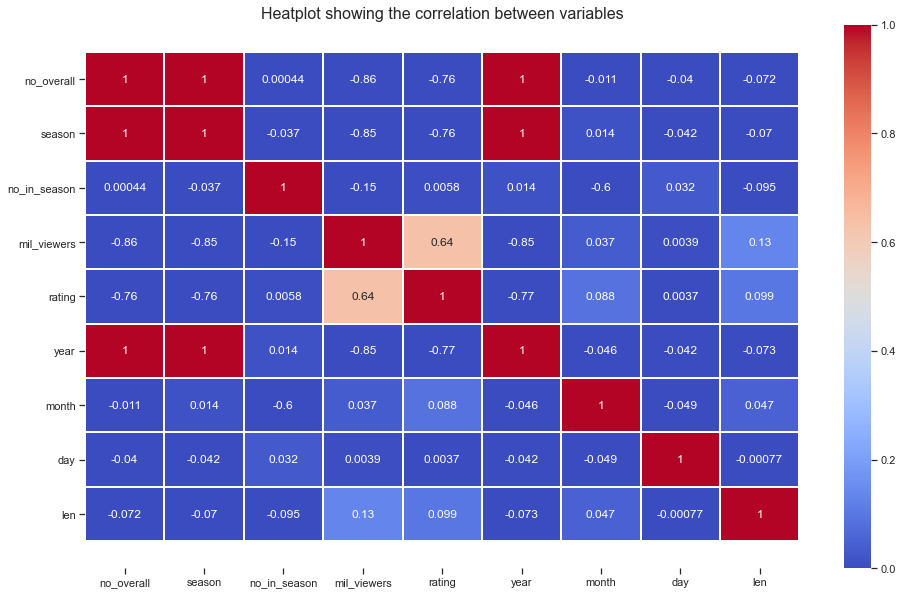

In [82]:
ax = sns.heatmap(df.corr(), annot=True,vmin=0.0, vmax=1.0, cmap='coolwarm',linewidths=1) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatplot showing the correlation between variables", size=16)
plt.show()

There seems to be some correlation between how many are watching the episode and how highly it is rated. 

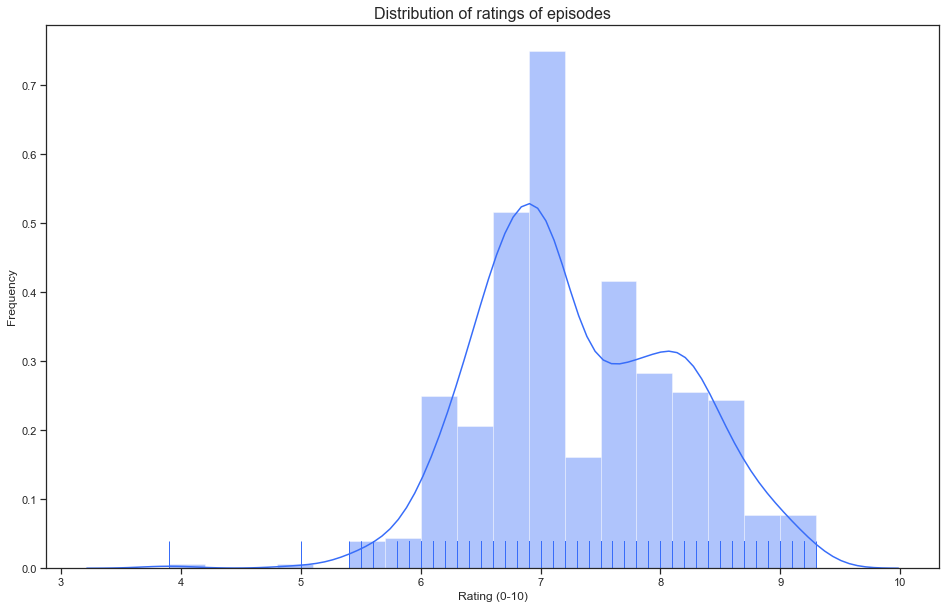

In [83]:
sns.set_palette('rainbow')
sns.distplot(df['rating'], rug=True)
plt.title("Distribution of ratings of episodes", size=16)
plt.xlabel("Rating (0-10)")
plt.ylabel("Frequency")
plt.show()

Most episodes are scoring a rating between 6 and 8.5

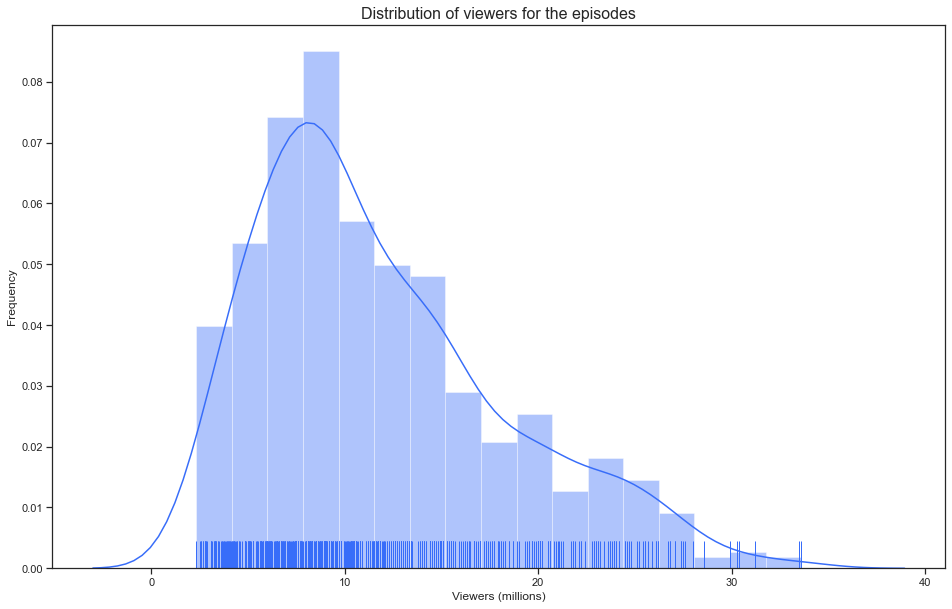

In [84]:
sns.distplot(df['mil_viewers'], rug=True)
plt.title("Distribution of viewers for the episodes", size=16)
plt.xlabel("Viewers (millions)")
plt.ylabel("Frequency")
plt.show()

Most episodes have around 5-15 million viewers. 

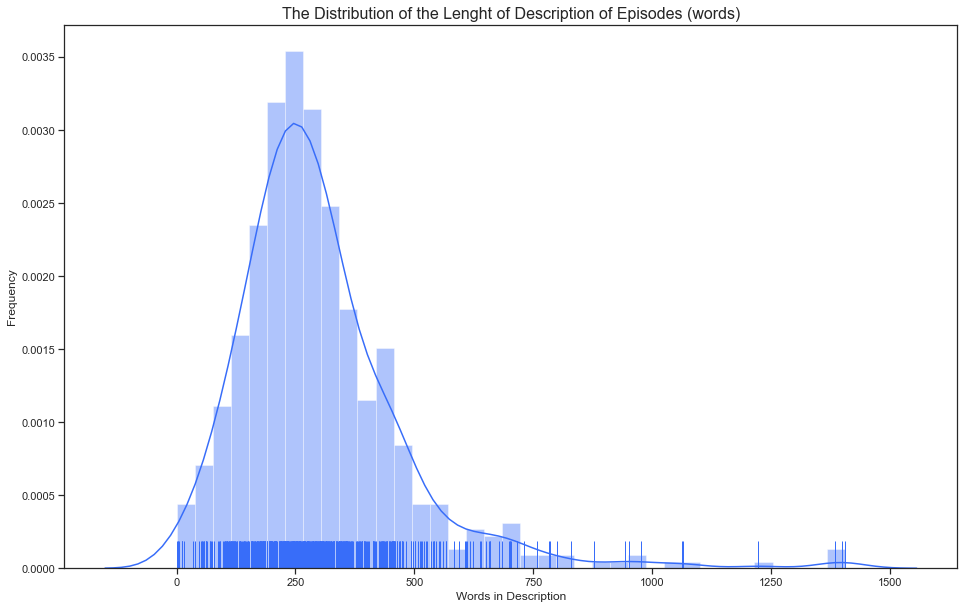

In [85]:
sns.distplot(df[df['len']>0]['len'], rug=True)
plt.title("The Distribution of the Lenght of Description of Episodes (words)", size=16)
plt.xlabel("Words in Description")
plt.ylabel("Frequency")
plt.show()

In the plot above it can be seen that most episodes have quite a large text that describes it.

# 5. Linear Regression - For comparison <a class="anchor" id="reg"></a>

In order to see if the new topical model is more accurate than a normal linear regression model, a simple linear regression model was created in order to try and predict the rating of an episode. 

In [86]:
df.columns

Index(['no_overall', 'season', 'no_in_season', 'episode_name', 'mil_viewers',
       'rating', 'year', 'month', 'day', 'desc', 'len', 'tf_idf'],
      dtype='object')

In [87]:
X = df[['no_overall','no_in_season','season','mil_viewers','year','month','day']].values

In [88]:
y = df['rating'].values

In [89]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [90]:
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [92]:
lm = LinearRegression()

In [93]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
predictions = lm.predict(X_test)

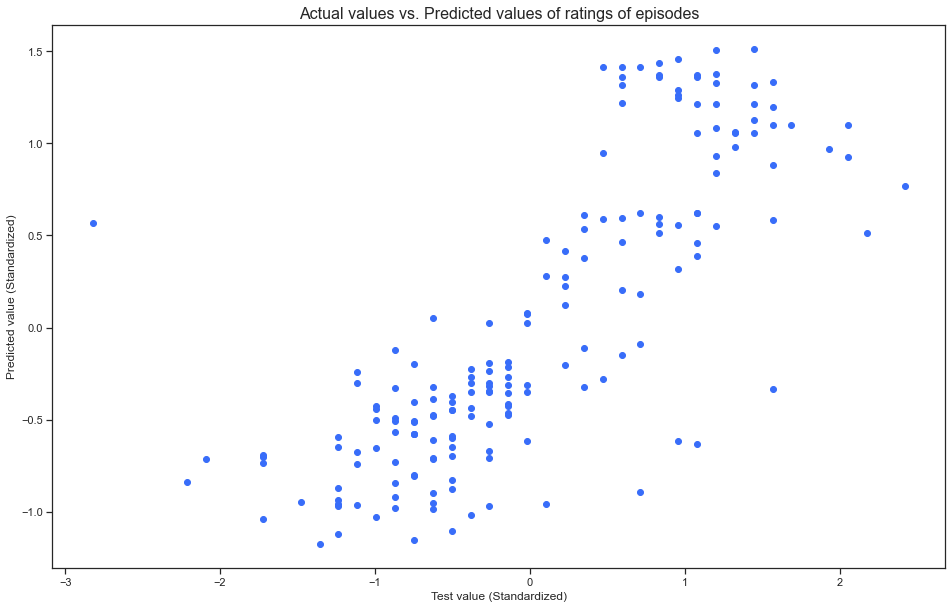

In [95]:
plt.scatter(y_test,predictions)
plt.title("Actual values vs. Predicted values of ratings of episodes", size=16)
plt.xlabel("Test value (Standardized)")
plt.ylabel("Predicted value (Standardized)")
plt.show()

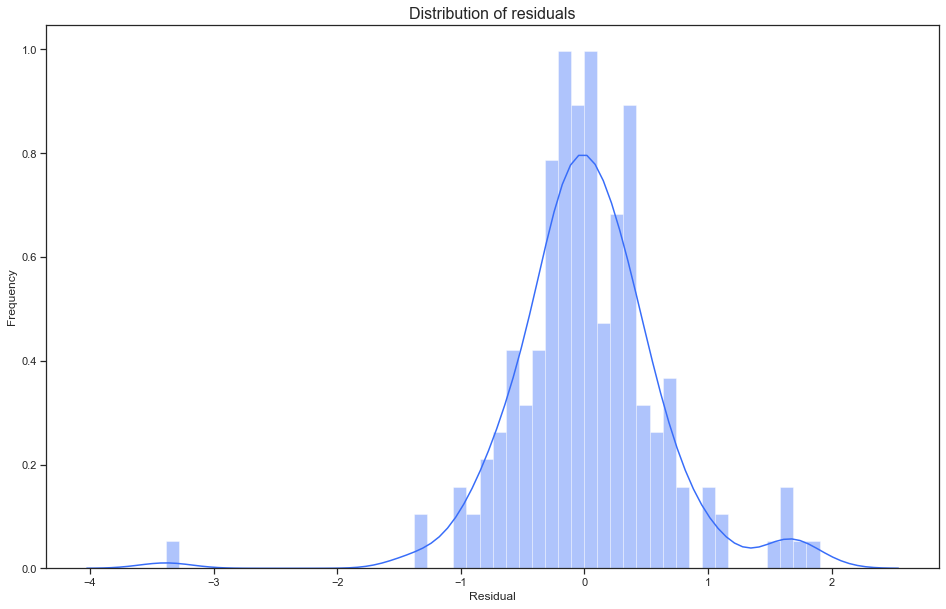

In [96]:
sns.distplot((y_test-predictions),bins=50);
plt.title("Distribution of residuals", size=16)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [97]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.42013206188779245
MSE: 0.3619117705003551
RMSE: 0.6015910325963604


From this it can be seen that creating a linear regression model in order to predict an episode's rating from other features is somewhat achievable.

# 6. Generative Story & PGM <a class="anchor" id="six"></a>

As we will deploy LDA for our topic model, the generative story for the inference of topics will follow the same generative story LDA follows. Here, we have changed the wording to fit our project. The following will be the generative story our model will follow: 

1. For each topic $k \in \{1,2,...,K\}$ where $K$ is the assumed total number of topics, there is a vector of $C$ words, $\phi_k$, such that $p(\theta_k|\beta) = \text{Dir}(\beta)$

2. For each document (*episode*) $i$:

>a) There is a vector of $K$ topics, $\theta_i$, such that $p(\theta_i|\alpha) = \text{Dir}(\alpha)$ 
    
>b) For each of the words $j$ in each episode $i$, where $j\in \{1,2,...,||w_i||\}$, we have
    
>>i) A **topic assignment** $z_{i,j} \in \{1,2,...,K\}$ such that $p(z_{i,j}|\theta_i) = \text{Cat}(\theta_i)$
    
>>ii) A **word** $w_{i,j}$ such that $p(w_{i,j}|\phi_{z_{i,j}}) = \text{Cat}(\phi_{z_{i,j}})$

What this means is that each episode will get assigned topic proportions and each topic will get assigned word proportions. 


### First version of our PGM

![title](pgm.png)

The first version of our PGM is shown here above. We plan to build on top of it, create a dynamic topic model with inspo from [here](https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf)

# 7. Stan Model <a class="anchor" id="eight"></a>

This section is highly inspired on Notebook 8 from this course. We will later build on top of it.

### Starting with ancestral sampling

"*Generate artificial data, and run inference on the
model using STAN to see if it is able to recover the true values/parameters
that were used to generate the data.*"

In [128]:
dfSample = df.sample(100)

Getting total number of words (after NLP) per episode.

In [129]:
df['length'] = df.tf_idf.apply(len)

I: number of episodes

In [100]:
I = len(dfSample)

J = ||w_i|| : number of words in each episode

K: number of topics, that we will play around with

In [101]:
K = 3

C: number of words in our dictionary

In [102]:
dictionary = dfSample.tf_idf.explode().unique()[:30] #starting with just the first 30 words for now
C = len(dictionary)

In [104]:
theta = np.zeros( (I, K));
beta = 0.5*np.ones(C) ## Size C
alpha = 0.5*np.ones(K) ## Size K
J=[] # cutting down number of the words per episode for this sample

for i in range(I):
    theta[i] = np.random.dirichlet(alpha);
    J.append(int(np.random.poisson(10)))
    

In [105]:
## Define word vectors (for each topic) and normalize:
phi = np.zeros( (K, C) );
for k in range(K): #topics
    phi[k] = np.random.dirichlet(beta) # ný prufa

In [106]:
phi

array([[1.32289945e-01, 2.43253819e-03, 4.27631120e-07, 3.20106073e-02,
        7.58639534e-02, 3.14849664e-02, 5.19674806e-02, 1.91870023e-02,
        1.04458424e-02, 2.02523868e-03, 7.87399472e-02, 6.48604050e-02,
        1.61900656e-02, 1.51330900e-02, 2.11374976e-02, 1.42936798e-02,
        1.16039818e-02, 6.32807234e-03, 1.77982124e-02, 7.27217524e-02,
        5.31448465e-03, 1.05173549e-01, 1.17964636e-04, 9.74581515e-03,
        9.28681323e-03, 2.74684566e-07, 1.16739217e-02, 1.35971427e-02,
        1.67798622e-01, 7.76706141e-04],
       [4.12836714e-02, 8.56298022e-02, 9.59440229e-02, 6.25921594e-03,
        8.88098109e-03, 3.20168858e-03, 3.31811587e-03, 2.92185821e-02,
        7.78833973e-02, 3.36403959e-02, 1.37139834e-02, 5.66092261e-03,
        2.65722020e-02, 8.62385912e-03, 1.88623792e-03, 7.86890342e-02,
        1.76453307e-02, 1.05505241e-02, 4.40366187e-03, 6.06254254e-03,
        1.34153500e-01, 4.89594975e-03, 1.27957823e-03, 3.55537387e-02,
        1.72071289e-01,

<font color=red> When we ran the above for phi, we didn't get the expected results. Would have thought we could do the same as we did with theta, but we'll have to look into how we can properply define phi. </font>

In [117]:
## Define word vectors (for each topic) and normalize:
phi = np.zeros( (K, C) );
phi[0] = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
phi[0] *= 1/np.sum(phi[0])
phi[1] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
phi[1] *= 1/np.sum(phi[1])
phi[2] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
          0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
phi[2] *= 1/np.sum(phi[2])

In [118]:
def categorical_sample(p):
    return list(np.random.multinomial(1, p)).index(1)

def ancestral_sampling(J, theta, phi):
    ## Initialise
    z = np.zeros( (I, np.max(J)), dtype=int )  
    w = np.zeros( (I, np.max(J)), dtype=int )

    for i in range(I):
        for j in range(J[i]):
            z[i, j] = categorical_sample(theta[i])
            w[i, j] = categorical_sample(phi[int(z[i, j])])
    return z, w

In [119]:
z, w = ancestral_sampling(J, theta, phi)

In [120]:
LDA_STAN="""
data{
    int<lower=1> I; 
    int<lower=1> J[I];  // We mean J=||W_i||
    int<lower=2> K; // # of topics
    int<lower=2> C; 
    vector<lower=0>[K] alpha;
    vector<lower=0>[C] beta;
    int<lower=2> MAX_J;
    int W[I,MAX_J];
}

parameters{
    simplex[K] theta[I];
    simplex[C] phi[K];
}

model{
    for (k in 1:K)
        phi[k]~dirichlet(beta);
        
    for (i in 1:I){
        theta[i]~dirichlet(alpha);
        
        for (j in 1:J[i]){
                real gamma[K];
                for (k in 1:K)
                    // log(P(z = k | theta)) + log(P(W | phi, z = k)) 
                    gamma[k]=log(theta[i,k])+log(phi[k,W[i][j]]);
                
                target+=(log_sum_exp(gamma)); //likelihood
        }
    }
}

"""

In [121]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


In [122]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

Extract results from STAN:

In [123]:
theta_hat = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

Compare estimated $\hat{\phi}$ with true values of $\phi$ used to generate the data:

In [124]:
np.argmax(phi, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [125]:
np.argmax(phi_hat, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

phi and phi_hat are matching.

In [126]:
J
print("w:", w)
for i in range(I):
    print("\n\nEpisode: ", i)
    print("Theta: ", theta[i])
    for j in range(J[i]):
        print("Word %d: Topic assignment: %d->   %s  " % (j,  z[i, j]+1, dictionary[w[i, j]]))

w: [[21 11 15 ...  0  0  0]
 [23 24 10 ...  0  0  0]
 [ 2  9  0 ...  0  0  0]
 ...
 [16 27 26 ...  0  0  0]
 [27 19 12 ...  0  0  0]
 [ 1 10  4 ...  0  0  0]]


Episode:  0
Theta:  [0.00643613 0.51537024 0.47819363]
Word 0: Topic assignment: 3->   enables  
Word 1: Topic assignment: 2->   shails  
Word 2: Topic assignment: 2->   craziest  
Word 3: Topic assignment: 3->   mechanic  
Word 4: Topic assignment: 3->   prison  
Word 5: Topic assignment: 2->   wrench  
Word 6: Topic assignment: 2->   recharger  
Word 7: Topic assignment: 2->   wrench  
Word 8: Topic assignment: 3->   mechanic  
Word 9: Topic assignment: 2->   shails  


Episode:  1
Theta:  [0.05249831 0.19939493 0.74810676]
Word 0: Topic assignment: 3->   jugs  
Word 1: Topic assignment: 3->   facefirst  
Word 2: Topic assignment: 2->   gliding  
Word 3: Topic assignment: 2->   craziest  


Episode:  2
Theta:  [0.72254251 0.23064244 0.04681505]
Word 0: Topic assignment: 1->   shock  
Word 1: Topic assignment: 1->   states  
W

### Full model, first version

Once we see that the model is correctly implemented and the inference also seems to be working correctly we can run it on bigger samples of our data, i.e. including all words per episode.

In [130]:
dfSample= dfSample[['rating','tf_idf', 'length']] # same sample as before,taking only the columns that we need

I: number of episodes

In [131]:
I = len(dfSample)

J = ||w_i|| : number of words in each episode

In [155]:
J = dfSample['length'].to_list()

#### Choosing K, the number of topics

with inspo from [here.](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#12buildingthetopicmodel).
temporary fix in a non-STAN LDA model. planning on finding a proper way to do this, if we won't succeed we'll use trial and error to find an ok value for K

In [134]:
data_lemmatized = df['tf_idf']#.to_list()
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
#print(corpus[:2])

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(17526 unique tokens: ['aboard', 'across', 'admire', 'alfie', 'amiss']...) from 600 documents (total 99201 corpus positions)


In [135]:
# Build LDA model
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.1
INFO:gensim.models.ldamodel:using symmetric eta at 0.1
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 10 topics, 10 passes over the supplied corpus of 600 documents, updating every 300 documents, evaluating every ~600 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 3 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #100/600, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #200/600, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #300/600, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #400/600, outstanding queue size 4
INFO:gensim.models

INFO:gensim.models.ldamodel:topic #0 (0.100): 0.002*"bart" + 0.002*"marge" + 0.002*"homer" + 0.001*"lisa" + 0.001*"springfield" + 0.001*"school" + 0.001*"back" + 0.001*"end" + 0.001*"made" + 0.001*"says"
INFO:gensim.models.ldamodel:topic #6 (0.100): 0.002*"bart" + 0.002*"lisa" + 0.002*"homer" + 0.002*"marge" + 0.002*"family" + 0.001*"take" + 0.001*"burns" + 0.001*"way" + 0.001*"school" + 0.001*"first"
INFO:gensim.models.ldamodel:topic #3 (0.100): 0.003*"lisa" + 0.002*"homer" + 0.002*"marge" + 0.002*"bart" + 0.002*"family" + 0.002*"springfield" + 0.002*"two" + 0.002*"take" + 0.002*"tells" + 0.001*"next"
INFO:gensim.models.ldamodel:topic #8 (0.100): 0.005*"homer" + 0.004*"bart" + 0.004*"marge" + 0.003*"lisa" + 0.003*"go" + 0.003*"springfield" + 0.003*"however" + 0.003*"tells" + 0.003*"gets" + 0.002*"family"
INFO:gensim.models.ldamodel:topic diff=0.619719, rho=0.333333
INFO:gensim.models.ldamodel:-9.650 per-word bound, 803.7 perplexity estimate based on a held-out corpus of 100 documents 

INFO:gensim.models.ldamodel:topic #0 (0.100): 0.002*"bart" + 0.001*"marge" + 0.001*"lisa" + 0.001*"homer" + 0.001*"says" + 0.001*"simpsons" + 0.001*"end" + 0.001*"school" + 0.001*"another" + 0.001*"springfield"
INFO:gensim.models.ldamodel:topic #8 (0.100): 0.005*"homer" + 0.004*"bart" + 0.004*"marge" + 0.004*"lisa" + 0.003*"go" + 0.003*"springfield" + 0.003*"gets" + 0.003*"however" + 0.003*"tells" + 0.003*"back"
INFO:gensim.models.ldamodel:topic #6 (0.100): 0.001*"bart" + 0.001*"school" + 0.001*"family" + 0.001*"lisa" + 0.001*"become" + 0.001*"place" + 0.001*"roll" + 0.001*"burns" + 0.001*"crowd" + 0.001*"maggie"
INFO:gensim.models.ldamodel:topic diff=0.296396, rho=0.301511
INFO:gensim.models.ldamodel:-9.215 per-word bound, 594.4 perplexity estimate based on a held-out corpus of 100 documents with 15778 words
INFO:gensim.models.ldamulticore:PROGRESS: pass 5, dispatched chunk #0 = documents up to #100/600, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 5, dispat

INFO:gensim.models.ldamulticore:PROGRESS: pass 7, dispatched chunk #5 = documents up to #600/600, outstanding queue size 6
INFO:gensim.models.ldamodel:merging changes from 300 documents into a model of 600 documents
INFO:gensim.models.ldamodel:topic #7 (0.100): 0.002*"lisa" + 0.001*"immediately" + 0.001*"school" + 0.001*"mother" + 0.001*"manages" + 0.001*"happens" + 0.001*"milhouse" + 0.001*"jar" + 0.001*"listening" + 0.001*"moe"
INFO:gensim.models.ldamodel:topic #0 (0.100): 0.002*"bart" + 0.001*"lisa" + 0.001*"simpsons" + 0.001*"head" + 0.001*"end" + 0.001*"song" + 0.001*"says" + 0.001*"school" + 0.001*"another" + 0.001*"body"
INFO:gensim.models.ldamodel:topic #6 (0.100): 0.001*"place" + 0.001*"proceeds" + 0.001*"burns" + 0.001*"bart" + 0.001*"school" + 0.001*"roll" + 0.001*"maggie" + 0.001*"family" + 0.001*"crowd" + 0.001*"become"
INFO:gensim.models.ldamodel:topic #3 (0.100): 0.002*"lisa" + 0.002*"homer" + 0.002*"bart" + 0.002*"marge" + 0.002*"family" + 0.002*"springfield" + 0.002*"t

INFO:gensim.models.ldamodel:merging changes from 300 documents into a model of 600 documents
INFO:gensim.models.ldamodel:topic #7 (0.100): 0.002*"lisa" + 0.001*"school" + 0.001*"principal" + 0.001*"immediately" + 0.001*"jar" + 0.001*"milhouse" + 0.001*"mother" + 0.001*"listening" + 0.001*"means" + 0.001*"skinner"
INFO:gensim.models.ldamodel:topic #1 (0.100): 0.003*"bart" + 0.002*"lisa" + 0.002*"mr" + 0.002*"school" + 0.002*"family" + 0.002*"life" + 0.002*"homer" + 0.002*"burns" + 0.001*"springfield" + 0.001*"marge"
INFO:gensim.models.ldamodel:topic #6 (0.100): 0.001*"roll" + 0.001*"proceeds" + 0.001*"school" + 0.001*"parody" + 0.001*"burns" + 0.001*"maggie" + 0.001*"crowd" + 0.001*"place" + 0.001*"hits" + 0.001*"god"
INFO:gensim.models.ldamodel:topic #2 (0.100): 0.002*"bart" + 0.002*"lisa" + 0.002*"homer" + 0.002*"get" + 0.002*"marge" + 0.002*"kids" + 0.002*"burns" + 0.002*"springfield" + 0.002*"ned" + 0.002*"family"
INFO:gensim.models.ldamodel:topic #3 (0.100): 0.002*"lisa" + 0.002*"b

In [136]:
from pprint import pprint
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [137]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v') #u_mass  eða c_v
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


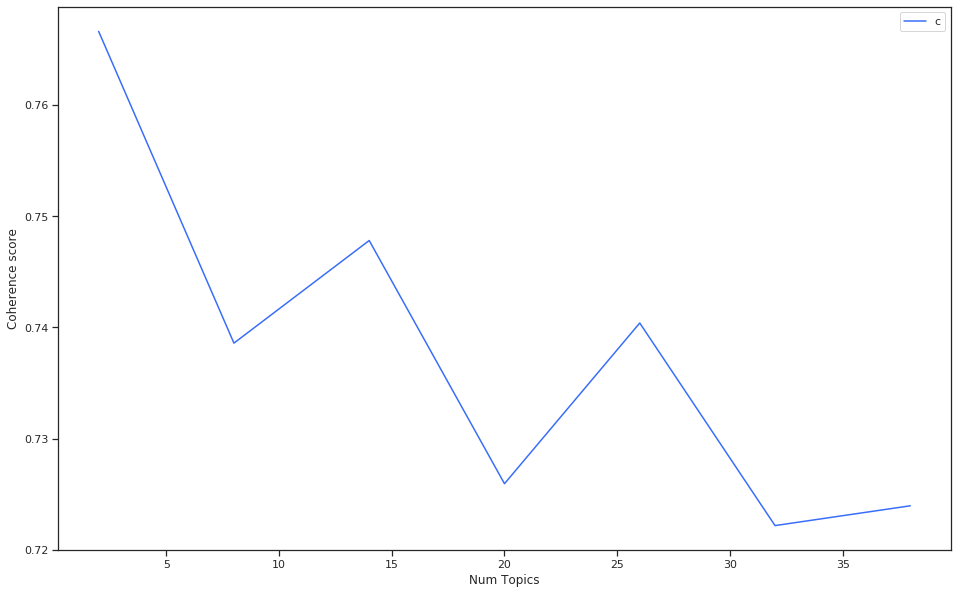

In [217]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

This suggests to use K as 32

In [139]:
K = 32

C: number of words in our dictionary

In [146]:
dictionary = dfSample.tf_idf.explode().unique() #starting with the first 30 for now
C = len(dictionary)

In [162]:
phi = np.zeros( (K, C) );
for k in range(K): #topics
    phi[k] = np.random.dirichlet(beta) 

In [163]:
def categorical_sample(p):
    return list(np.random.multinomial(1, p)).index(1)

def ancestral_sampling(J, theta, phi):
    ## Initialise
    z = np.zeros( (I, np.max(J)), dtype=int )  
    w = np.zeros( (I, np.max(J)), dtype=int )

    for i in range(I):
        for j in range(J[i]):
            z[i, j] = categorical_sample(theta[i])
            w[i, j] = categorical_sample(phi[int(z[i, j])])
    return z, w

In [164]:
theta = np.zeros( (I, K));
beta = 0.5*np.ones(C) ## Size C
alpha = 0.5*np.ones(K) ## Size K

for i in range(I):
    theta[i] = np.random.dirichlet(alpha);
    

In [165]:
z, w = ancestral_sampling(J, theta, phi)

In [166]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


CompileError: command 'clang' terminated by signal 6

In [ ]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

Extract results from STAN:

In [ ]:
theta_hat = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

Compare estimated $\hat{\phi}$ with true values of $\phi$ used to generate the data:

In [ ]:
np.argmax(phi, axis=0)

In [ ]:
np.argmax(phi_hat, axis=0)

phi and phi_hat are matching.

In [ ]:
J
print("w:", w)
for i in range(I):
    print("\n\nEpisode: ", i)
    print("Theta: ", theta[i])
    for j in range(J[i]):
        print("Word %d: Topic assignment: %d->   %s  " % (j,  z[i, j]+1, dictionary[w[i, j]]))

# 8. Conclusion <a class="anchor" id="conclusion"></a>

Our research question;
> How do the topic proportions align with the episodes and can they be used to determine an episode's rating
